## Case: Hospital
Implenting data as it is stored in a relational database.

### Employee data
Need
- Number of hours each employee is contracted to work
- Hourly salary for each employee

In [118]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Random")
Pkg.add("Statistics")
Pkg.add("Dates")
Pkg.add("Gurobi");
Pkg.add("JuMP");
Pkg.add("Plots")
using CSV, DataFrames, Random, Statistics, Dates, Gurobi, JuMP, Plots;

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Chan

In [131]:
FTE_rates = vcat(fill(1.0, 15), fill(0.75, 8), fill(0.7, 3), fill(0.5, 4))
Random.seed!(42)
wages = [round((randn() * 3.0 + 20), digits=2) for rate in FTE_rates]
employees = DataFrame(FTE_rate = FTE_rates, wage = wages);
CSV.write("data/employees.csv", employees)
employees

Row,FTE_rate,wage
,Float64,Float64
1,1.0,22.37
2,1.0,17.36
3,1.0,17.38
4,1.0,17.8
5,1.0,17.89
6,1.0,19.78
7,1.0,17.26
8,1.0,21.89
9,1.0,24.32


### Shift data

In [132]:
num_shifts = 30  # number of shifts to generate
num_days = 28
start_dates = [Date(2024, 1, 1) + Day(i-1) for i in 1:num_days]
start_times = [Time(7,0), Time(15,0), Time(23,0) ]
shift_durations = [4,6,8,10]

shifts = DataFrame(date = Date[], start_time = Time[], duration = Float64[], required_workers = Int[])

Random.seed!(42)
for start_date in start_dates, start_time in start_times
    push!(shifts, (start_date, start_time, rand(shift_durations), rand(1:10)))
end
CSV.write("data/shifts.csv", shifts)
shifts

Row,date,start_time,duration,required_workers
,Date,Time,Float64,Int64
1,2024-01-01,07:00:00,8.0,5
2,2024-01-01,15:00:00,6.0,8
3,2024-01-01,23:00:00,8.0,2
4,2024-01-02,07:00:00,8.0,7
5,2024-01-02,15:00:00,6.0,3
6,2024-01-02,23:00:00,8.0,7
7,2024-01-03,07:00:00,6.0,3
8,2024-01-03,15:00:00,8.0,1
9,2024-01-03,23:00:00,6.0,2


## Optimization 

Data

In [133]:
D = shifts[!,"required_workers"]
L = shifts[!,"duration"]
S = employees[!,"wage"]
R = employees[!,"FTE_rate"]
epsilon = 0.05
hours_in_month = 40*4

n = nrow(employees)
m = nrow(shifts)

model = Model(Gurobi.Optimizer)
@variable(model, Z[1:n], Bin) # Binary variable whether employee p should be included in schedule or not
@variable(model, X[1:n, 1:m], Bin)
@objective(model, Min, sum(sum(X[p,s]*L[s]*S[p] for s in 1:m) for p in 1:n))
@constraint(model, zx_constraint[p in 1:n, s in 1:m], X[p,s] <= Z[p])
@constraint(model, demand_constraint[s in 1:m], sum(X[p,s] for p in 1:n) >= D[s])
@constraint(model, FTE_lower_constraint[p in 1:n], sum(X[p,s]*L[s] for s in 1:m) >= R[p]*hours_in_month*(1-epsilon)*Z[p])
@constraint(model, FTE_upper_constraint[p in 1:n], sum(X[p,s]*L[s] for s in 1:m) <= R[p]*hours_in_month*(1+epsilon)*Z[p])
optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-07
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2664 rows, 2550 columns and 12660 nonzeros
Model fingerprint: 0xfd87c30b
Variable types: 0 continuous, 2550 integer (2550 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [6e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve time: 0.04s
Presolved: 2664 rows, 2550 columns, 12660 nonzeros
Variable types: 0 continuous, 2550 integer (2550 binary)
Found heuristic solution: objective 76925.920000
Found heuristic solution: objective 60533.820000

Root relaxation: objective 5.712872e+04, 590 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent  

In [134]:
X_opt = value.(X)
employees.nr_shifts = sum(X_opt, dims=2) |> vec
employees.hours = X_opt*L
employees

Row,FTE_rate,wage,nr_shifts,hours
,Float64,Float64,Float64,Float64
1,1.0,22.37,0.0,0.0
2,1.0,17.36,25.0,168.0
3,1.0,17.38,20.0,168.0
4,1.0,17.8,24.0,168.0
5,1.0,17.89,25.0,168.0
6,1.0,19.78,22.0,168.0
7,1.0,17.26,26.0,168.0
8,1.0,21.89,22.0,152.0
9,1.0,24.32,0.0,0.0


Row,FTE_rate,wage,nr_shifts,hours
,Float64,Float64,Float64,Float64
1,1.0,22.37,0.0,0.0
2,1.0,24.32,0.0,0.0
3,1.0,22.39,0.0,0.0
4,1.0,22.86,0.0,0.0
5,0.75,23.51,0.0,0.0
6,0.75,23.4,0.0,0.0
7,0.5,21.95,0.0,0.0
8,0.5,24.01,0.0,0.0


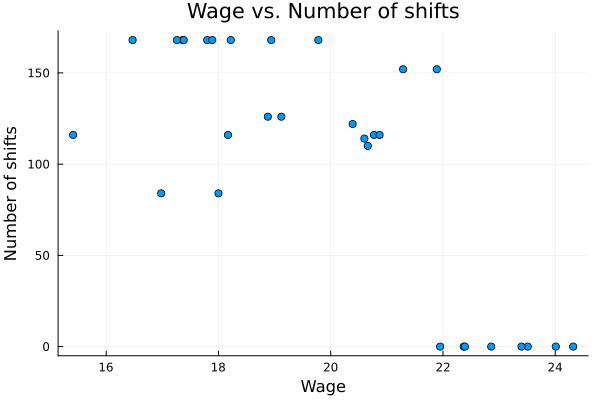

In [135]:
display(employees[employees.hours .== 0, :])
scatter(employees.wage, employees.hours, title="Wage vs. Number of shifts", 
    xlabel="Wage", ylabel="Number of shifts", legend=false)

Things to comment:
- Including availability here would make the model very prone to reaching infeasibility on holidays if nobody wants to work on thanksgiving.
- This model simply chooses the employers with lower wages over those with higher, meaning that more experienced employers will lose their jobs
